### Import libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

### Load processed dataset

In [2]:
path = '../data/'
train = pd.read_csv(path+'processed-train.csv',delimiter=',')
test = pd.read_csv(path+'processed-test.csv',delimiter=',')
train.head()

,age,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,0.020008,7,1,-0.197592,0.845278,0.599115,-0.492143,0.772161,0.865359,-1,...,0,0,0,0,0,1,0,1,1,0
1,-0.931606,5,1,0.976451,-1.229913,-1.281918,-1.329137,-1.380273,-1.009784,-1,...,0,0,0,1,0,0,0,0,1,0
2,1.923236,5,1,2.150493,-1.229913,-1.281918,-1.329137,-1.316557,-1.009784,-1,...,0,0,0,0,0,0,0,0,0,0
3,0.337212,7,2,1.563472,0.845278,0.599115,-0.492143,0.772740,0.865359,-1,...,0,0,0,0,0,1,0,0,1,0
4,-0.085727,5,4,-0.197592,0.650729,0.738587,1.014446,0.714238,0.326073,-1,...,1,0,0,0,0,0,0,1,1,0


### Split data into features and labels

In [3]:
# Predictors
x_train = train.drop(['y'], 1)
x_test = test.drop(['y'], 1)

# Target values
y_train = train['y']
y_test = test['y']

### Baseline algorithms

Let us run some baseline algorithms with default hyper-parameters on the training data to see how they perform. We will consider the following algorithms: **Logistic regression**, **Decision tree**, **Random forest**, **Gradient boosting classifier** and **k-Nearest neighbor**. For each algorithm, we will perform 5-fold cross-validation on the training set and store the mean classification accuracy and mean AUC-ROC (Area under ROC curve) along with the standard deviations.

In [14]:
# Make a list of algorithms to implement
models = []
models.append(('Logistic regression', LogisticRegression(max_iter=500)))
models.append(('Decision tree', DecisionTreeClassifier()))
models.append(('Random forest', RandomForestClassifier()))
models.append(('Gradient boosting classifier', GradientBoostingClassifier()))
models.append(('k-Nearest neighbor', KNeighborsClassifier()))

In [15]:
# Make a dataframe to store classification metrics
col = ['Algorithm', 'Mean ROC-AUC', 'S.D. AUC-ROC', 'Mean Accuracy', 'S.D. Accuracy']
df_results = pd.DataFrame(columns=col)
auc_results = []
acc_results = []
i = 0

# Fit the models one by one
for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)  # 5-fold cross-validation
    cv_auc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    auc_results.append(cv_auc_results)
    cv_acc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    acc_results.append(cv_acc_results)
    df_results.loc[i] = [name,
                         cv_auc_results.mean(),
                         cv_auc_results.std(),
                         cv_acc_results.mean(),
                         cv_acc_results.std()
                         ]
    i += 1
    print(i)
df_results.sort_values(by=['Mean ROC-AUC'], ascending=False)

1
2
3
4
5


,Algorithm,Mean ROC-AUC,S.D. AUC-ROC,Mean Accuracy,S.D. Accuracy
3,Gradient boosting classifier,0.803000,0.002390,0.901517,0.001863
0,Logistic regression,0.781741,0.004751,0.900455,0.002460
2,Random forest,0.773915,0.005955,0.893778,0.001556
4,k-Nearest neighbor,0.731798,0.003539,0.887284,0.001771
1,Decision tree,0.628307,0.009362,0.842124,0.006300


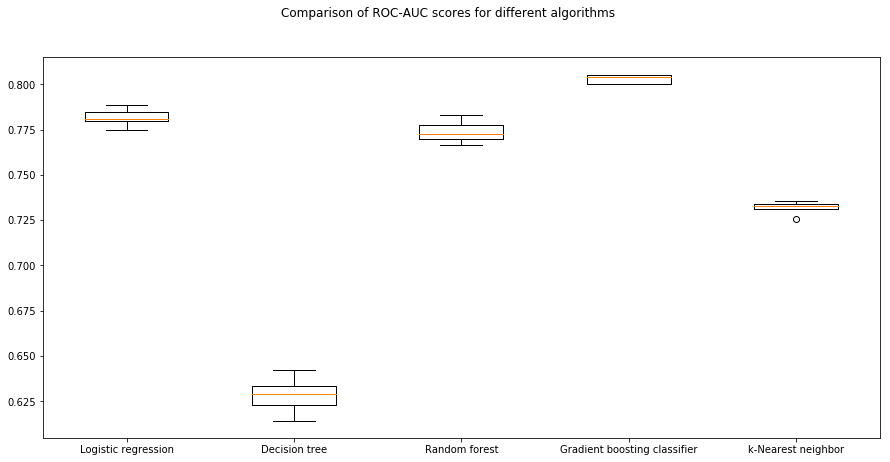

In [16]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Comparison of ROC-AUC scores for different algorithms')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(df_results['Algorithm'])
plt.show()

So although the classification accuracies for all the models except decision tree are more or less similar, it is not the right indicator because of the class imbalance. Going by the ROC-AUC score, which quantifies a classifier's ability to differentiate between the classes, gradient boosting classifier and logistic regression are better baseline models.

## Feature selection using Recursive Feature Elimination

Let us use RFE to automatically select features using the random forest classifier and see if using a subset of features can improve classification performance over the baseline for the two most promising candidate algorithms: gradient boosting classifier and logistic regression.

In [26]:
#rfe = RFECV(estimator=RandomForestClassifier())
#model = GradientBoostingClassifier()
#pipeline = Pipeline(steps=[('s',rfe),('m',model)])
#n_scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', n_jobs=-1, error_score='raise')
#print('ROC-AUC score: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))